Python script to run MCMC-GAN inference on simulated data to predict multiple demographic parameters jointly.

Installation of the required libraries:

In [ ]:
%%capture
# Installing required libraries
!apt-get install python-dev libgsl0-dev
 
# The latest version of tskit 0.3 gives problem with msprime
!pip install tskit==0.2.3 zarr msprime stdpopsim tensorflow

Import the necessary libraries and GPU settings:

In [ ]:
# Importing libraries and modules
import msprime
import stdpopsim
import zarr
import random
import pickle
import imageio
import bisect
import time
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import tensorflow_probability as tfp
print(tfp.__version__)
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 

# Mount my Gdrive disk
from google.colab import drive, files
drive.mount('/content/gdrive')
!mkdir /content/results


2.3.0
0.11.0
Mounted at /content/gdrive


Parameter and Genobuilder classes. The object from these classes are used to generate genotype matrices from different sources of evolutionary models or variant data.

In [ ]:
class Parameter():

    def __init__(self, name, idx, val, bounds, log=False, **kwargs):

      self.name = name
      self.idx = idx
      if log:
        self.val = np.float_power(10, val)
      else:
        self.val = val
      self.bounds = bounds
      self.log = log
      super(Parameter, self).__init__(**kwargs)



    def set_gauss(self, mean, std):

      self.gauss_mean = mean
      self.gauss_std = std



    def rand(self):

      min, max = self.bounds
      x = np.random.uniform(min, max)

      if self.log:
        return np.float_power(10, x)
      else:
        return x



    def rand_gauss(self):

      if self.log:
        return np.float_power(10, np.random.normal(
                                self.gauss_mean, self.gauss_std))
      else:
        return np.random.normal(self.gauss_mean, self.gauss_std)




class Genobuilder():
    """Class for building genotype matrices from msprime, stdpopsim
      or empirical data read from Zarr directories, and other utilities
      relates to these"""

    def __init__(self, source, num_samples, seq_len, maf_thresh,
                 fixed_dim = 128, scale=False, **kwargs):
      self._num_samples = num_samples
      self._seq_len = seq_len
      self._maf_thresh = maf_thresh
      self._source = source
      self._fixed_dim = fixed_dim
      self._scale = scale
      self._param_bounds = None
      self._num_reps = None
      super(Genobuilder, self).__init__(**kwargs)


    def set_parameters(self, sim_source, params, log=False):

      self._sim_source = sim_source
      self._params = params
      self.log = log


    @property
    def num_samples(self):
      return self._num_samples

    @property
    def seq_len(self):
      return self._seq_len

    @property
    def maf_thresh(self):
      return self._maf_thresh

    @property
    def source(self):
      return self._source

    @property
    def fixed_dim(self):
      return self._fixed_dim

    @property
    def num_reps(self):
      return self._num_reps

    @property
    def params(self):
      return self._params

    @property
    def sim_source(self):
      return self._sim_source

    @property
    def scale(self):
      return self._scale

    @num_samples.setter
    def num_samples(self, n):
      if type(n) != int or n < 0:
        raise ValueError('Genobuilder num_samples must be a positive integer')
      self._num_samples = n

    @maf_thresh.setter
    def maf_thresh(self, maf):
      if maf < 0 or maf > 1:
        raise ValueError('The Minor Allele Frequency must be between 0 and 1')
      self._maf_thresh = maf

    @seq_len.setter
    def seq_len(self, l):
      self._seq_len = int(l)

    @source.setter
    def source(self, s):
      if s not in ['msprime', 'stdpopsim', 'empirical']:
        raise ValueError('Genobuilder source must be either msprime, '
                         'stdpopsim or empirical')
      self._source = s

    @fixed_dim.setter
    def fixed_dim(self, f):
      if f % 2 != 0:
        raise ValueError('We recommend the fixed dimension to be multiple of 2')
      self._fixed_dim = f

    @num_reps.setter
    def num_reps(self, n):
      self._num_reps = n


    @params.setter
    def params(self, p):
      self._params = p

    @sim_source.setter
    def sim_source(self, s):
      if s not in ['msprime', 'stdpopsim']:
        raise ValueError('Genobuilder sim_source must be either',
                         'msprime or stdpopsim')
      self._sim_source = s



    def simulate_msprime(self, params=None, seed=None):
      """Simulate demographic data, returning a tensor with n_reps number
      of genotype matrices"""

      if params == None:
        params = self.params

      sims = msprime.simulate(
          sample_size=self.num_samples, Ne=params['effective size'].val,
          length=self.seq_len, mutation_rate=params['mutation rate'].val,
          recombination_rate=params['recombination rate'].val,
          num_replicates=self.num_reps, random_seed=seed
          )

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))


      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def simulate_msprime_generator(self, params, seed=None):
      """Simulate demographic data, returning a tensor with n_reps number
      of genotype matrices"""

      if self.log:
        params = [np.float_power(10, p) for p in params]

      sims = msprime.simulate(
          sample_size=self.num_samples, Ne=params[2], length=self.seq_len,
          mutation_rate=params[1], recombination_rate=params[0],
          num_replicates=self.num_reps, random_seed=seed
          )

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))


      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def _simulate_msprime_list(self, param_vals=None, seed=None, gauss=False):
      """Simulate demographic data, returning a tensor with n_reps number of
      genotype matrices. Here, params is a list of values, not a single scalar"""

      if gauss:
        sims = msprime.simulate(
            sample_size=self.num_samples,
            Ne=self.params['effective size'].rand_gauss(),
            length=self.seq_len,
            mutation_rate=self.params['mutation rate'].rand_gauss(),
            recombination_rate=self.params['recombination rate'].rand_gauss(),
            num_replicates=self.num_reps,
            random_seed=seed
            )
      else:
        sims = msprime.simulate(
            sample_size=self.num_samples,
            Ne=self.params['effective size'].rand(),
            length=self.seq_len,
            mutation_rate=self.params['mutation rate'].rand(),
            recombination_rate=self.params['recombination rate'].rand(),
            num_replicates=self.num_reps,
            random_seed=seed
            )


      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def _parse_empiricaldata(self, haplotype):

      # Set up some data paths
      mask_file = "/content/gdrive/My Drive/mcmcgan/20140520.pilot_mask.autosomes.bed"
      zarr_path = "/content/gdrive/My Drive/mcmcgan/zarr"

      # Locate the data contained in zarr
      callset = zarr.open_group(zarr_path, mode='r')

      num_samples = len(callset['1/samples'])

      data = np.zeros((self.num_reps, num_samples, self.fixed_dim))

      # Get lists of randomly selected chromosomes and genomic locations
      chroms, pos, slices = self._random_sampling_geno(
          callset, mask_file=mask_file)

      # For each randomly sampled genomic location
      for i, (chrom, pos, loc_region) in enumerate(zip(chroms, pos, slices)):
        print(f'it {i}  :  chromosome {chrom}  :  position {pos}')

        # Extract genotype and genomic position for the variants for all samples
        gt_zarr = np.asarray(callset[f'{chrom}/calldata/GT'][loc_region])
        pos_zarr = callset[f'{chrom}/variants/POS'][loc_region]
        alt_zarr = callset[f'{chrom}/variants/ALT'][loc_region]

        # Make sure the genome is diploid, and extract one of the haplotypes
        assert gt_zarr.shape[2] == 2, "Samples are not diploid"
        hap = self._haploidify(gt_zarr, haplotype)

        # To check the number of 0s and 1s in each gt
        # Filtering missing data by looking at -1? No -1 in 1000 genomes data.
        #unique, counts = np.unique(hap, return_counts=True)
        #print(dict(zip(unique, counts)))

        # Get the relative position in the sequence length to resize the matrix
        relative_pos = pos_zarr - pos

        data[i] = self._resize_from_zarr(hap, relative_pos, alt_zarr)

      if self.scale:
        data = scale_matrix(data)

      data = np.expand_dims(data, axis=-1)

      return data



    def simulate_stdpopsim(self, engine, species, model, pop,
                            error_prob=None, seed=None):

      stdengine = stdpopsim.get_engine(engine)
      stdspecies = stdpopsim.get_species(species)
      stdmodel = stdspecies.get_demographic_model(model)

      geno = [(i, get_chrom_size(i)) for i in range(1, 23)]
      # Sort the list by size.
      geno.sort(key=lambda a: a[1], reverse=True)
      cum_weights = []
      rng = random.Random(seed)
      for i, (chrom, size) in enumerate(geno):
          cum_weights.append(size if i == 0 else size + cum_weights[i-1])

      # The order for sampling from populations is ['YRI', 'CEU', 'CHB']
      if pop=='YRI':
        stdsamples = stdmodel.get_samples(self.num_samples, 0, 0)
      elif pop=='CEU':
        stdsamples = stdmodel.get_samples(0, self.num_samples, 0)
      elif pop=='CHB':
        stdsamples = stdmodel.get_samples(0, 0, self.num_samples)

      sims = []
      for i in range(self.num_reps):
        chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]
        factor = self.seq_len/size
        stdcontig = stdspecies.get_contig(
            'chr' + str(chrom), length_multiplier=factor)
        sims.append(stdengine.simulate(stdmodel, stdcontig, stdsamples))

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):

        if type(error_prob) is float:
          mat[i] = self._mutate_geno_old(ts, p=error_prob)

        elif type(error_prob) is np.ndarray:
          mat[i] = self._mutate_geno_old(ts, p=error_prob[i])

        # No error prob, it doesn't mutate the matrix
        else:
          mat[i] = self._resize_from_ts(ts)


      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def generate_data(self, num_reps, paramlist=None, gauss=False):
      #Generate (X, y) data from demographic simulations.

      self.num_reps = num_reps

      print(f'generating {num_reps} genotype matrices from {self.source}')
      if self.source=='stdpopsim':
        gen1 = self.simulate_stdpopsim(engine='msprime', species='HomSap',
                            model='OutOfAfricaArchaicAdmixture_5R19', pop='CEU',
                            error_prob=None)

      elif self.source=='empirical':
        gen1 = self._parse_empiricaldata(haplotype = 0)

      elif self.source=='msprime':
        gen1 = self.simulate_msprime(seed=None)

      print(f'generating {num_reps} genotype matrices from {self.sim_source}')


      print(paramlist)
      if self.sim_source=='msprime':
        gen0 = self._simulate_msprime_list(seed=None, gauss=gauss)

      X = np.concatenate((gen1, gen0))
      y = np.concatenate((np.ones((num_reps)), np.zeros((num_reps))))
      print(f'X data shape is: {X.shape}')


      #Split randomly into training and test data.
      return train_test_split(X, y, test_size=0.1)



    def generate_testdata(self, num_reps, testlist=None):

      self.num_reps = num_reps

      print(f'generating {num_reps} genotype matrices from ' \
            f'{self.sim_source} for testing')

      if self.sim_source=='msprime':
        x_test = self._simulate_msprime_list(seed=None)

      return x_test



    def generator_iterator(self, num_reps):

      self.num_reps = num_reps

      print(f'generating {num_reps} genotype matrices with different'
            f' {self.param_name} from {self.sim_source} for testing')

      if self.sim_source=='msprime':
        x = self.simulate_msprime(seed=None)
      if self.sim_source=='stdpopsim':
        x = self.simulate_stdpopsim(engine='msprime', species='HomSap',
                            model='OutOfAfricaArchaicAdmixture_5R19',
                            pop='CEU', error_prob=p_val, seed=None)

      yield x



    def _mutate_geno_old(self, ts, p=0.001):
      """Returns a genotype matrix with a fixed number of columns,
      as specified in x"""

      rows = int(self.num_samples)
      cols = int(self.seq_len)
      m = np.zeros((rows, cols), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          m[:, int(variant.site.position)] += variant.genotypes

      m = m.flatten()
      n = np.random.binomial(len(m), p)
      idx = np.random.randint(0, len(m), size=n)
      m[idx] = 1 - m[idx]
      m = m.reshape((rows, cols))

      f = int(cols/self.fixed_dim)
      mat = np.zeros((rows, self.fixed_dim), dtype=float)

      for i in range(self.fixed_dim):
        s = i*f
        e = s + f - 1
        mat[:, i] = np.sum(m[:, s:e], axis=1)

      return mat



    def _mutate_geno(self, ts, p=0.001, flip=True):
      """Returns a genotype matrix with a fixed number of columns,
      as specified in x"""

      rows = int(self.num_samples)
      cols = int(self.fixed_dim)
      m = np.zeros((rows, cols), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          # Polarise the matrix by major allele frequency.
          if flip:
              af = np.mean(variant.genotypes)
              if af > 0.5 or (af == 0.5 and random.Random() > 0.5):
                  variant.genotypes = 1 - variant.genotypes


          n = np.random.binomial(len(variant.genotypes), p)
          if n is not None:
              idx = np.random.randint(0, len(variant.genotypes), size=n)
              variant.genotypes[idx] = 1 - variant.genotypes[idx]

          j = int(variant.site.position * self.fixed_dim / ts.sequence_length)
          np.add(m[:, j], variant.genotypes, out=m[:,j],
                 where= variant.genotypes != -1)


      return m



    def _random_sampling_geno(self, callset, mask_file = None, seed = None):
      """random sampling from chromosome based on the proportional
      size and the mask"""

      # Extract chromosome number and length from stdpopsim catalog
      geno = [(i, get_chrom_size(i)) for i in range(1, 23)]

      # Sort the list by size.
      geno.sort(key=lambda a: a[1], reverse=True)

      cum_weights = []
      for i, (chrom, size) in enumerate(geno):
          cum_weights.append(size if i == 0 else size + cum_weights[i-1])

      print("Charging up the chromosomes")
      locs = [0]
      for i in range(1, 23):
        print(f"Charging chromosome {i}")
        query = f"{i}/variants/POS"
        locs.append(np.asarray(callset[query]))

      mask = load_mask(mask_file, min_len = 10000) if mask_file else None

      rng = random.Random(seed)
      chroms, slices, mask_ranges, pos = [], [], [], []

      while len(chroms) < self.num_reps:
        chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]

        assert size > self.seq_len
        proposal = rng.randrange(0, size - self._seq_len)

        if mask:
          for start, end in mask[str(chrom)]:
            if start < proposal < end:
              chroms.append(chrom)
              pos.append(proposal)
              slices.append(locate(
                  locs[chrom], start=proposal, stop=proposal + self._seq_len))

        else:
          chroms.append(chrom)
          pos.append(proposal)
          slices.append(locate(
              locs[chrom], start=proposal, stop=proposal + self.seq_len))

      return chroms, pos, slices



    def _resize_from_ts(self, ts, flip=True):
      """Returns a genotype matrix with a fixed number of columns,
      as specified in size"""

      m = np.zeros((ts.num_samples, self.fixed_dim), dtype=float)
      flip = {0: 1, 1: 0, -1: -1}

      for variant in ts.variants():

          # Calculate allele frequency
          af = np.mean(variant.genotypes)

          # Filter by MAF
          if self.maf_thresh is not None:
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          # Polarise the matrix by major allele frequency.
          if flip:
              if af > 0.5 or (af == 0.5 and random.Random() > 0.5):
                  variant.genotypes = [flip[b] for b in variant.genotypes]

          j = int(variant.site.position * self.fixed_dim / ts.sequence_length)
          np.add(m[:, j], variant.genotypes, out=m[:,j],
                 where= variant.genotypes != -1)

      return m



    def _resize_from_zarr(self, mat, pos, alts, flip=True):
      """Resizes a matrix using a sum window, given a genotype matrix,
      positions vector,sequence length and the desired fixed size
      of the new matrix"""

      # Initialize empty matrix with the new dimensions
      m = np.zeros((mat.shape[1], self.fixed_dim), dtype=mat.dtype)
      flip = {0: 1, 1: 0, -1: -1}

      # Fill in the resized matrix
      for _pos, _gt, _alt in zip(pos, mat, alts):

          """
          # Check that all the SNPs are biallelic
          if np.count_nonzero(_alt) != 1:
              print('found')
              continue
          """

          # Calculate allele frequency
          af = np.mean(_gt)

          # Filter by MAF
          if self.maf_thresh is not None:
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          # Polarise the matrix by major allele frequency.
          if flip:
              if af > 0.5 or (af == 0.5 and random.Random() > 0.5):
                  _gt = [flip[b] for b in _gt]

          j = int(_pos * self.fixed_dim / self.seq_len) - 1
          np.add(m[:, j], _gt, out=m[:, j], where=_gt != -1)

      return m



    def _haploidify(self, genmat, h):
      """Returns the selected haplotype from a numpy array with
      a ploidy dimension. The parameter h must be either 0 or 1"""

      if h in [0, 1, 2]:
          if h == 2:
            self.num_samples *= 2
            return np.concatenate((genmat[:, :, 0], genmat[:, :, 1]))
          else:
            return genmat[:, :, h]

      print('The parameter h must be 0 or 1 for one haplotype, or 2 for both')
      return





def filter_maf(gt, pos, maf):
    """Filter a genotype matrix gt and the SNP position vector pos in base of
    the desired Minor Allele Frequency maf parameter"""

    # Filter alleles and position where af > maf_threshold i.e. 0.05
    af = np.mean(gt, axis=1)
    condition = af > maf
    gt = gt[np.array(condition), :]
    pos = pos[condition]

    # Filter alleles and position where af > 1 - maf_threshold i.e. 0.95
    af = np.mean(gt, axis=1)
    condition = af < 1 - maf
    gt = gt[np.array(condition), :]
    pos = pos[condition]

    return gt, pos



def load_mask(mask_file, min_len):
      """Given a mask file in BED format, parse the mask data and
      returns a matrix of tuples containing the permited regions,
      as (start, end) positions"""

      # Initialize empty mask dictionary
      mask = {str(k): [] for k in range(1, 23)}

      # Read through the lines and add to the dictionary for each chrom
      with open(mask_file, 'r') as file:
        for line in file:
          chrom, start, end, _ = line.split()
          start, end = int(start), int(end)

          if (end - start) > min_len:
            mask[chrom[3:]].append((int(start), int(end)))

        file.close()

      return mask



def get_chrom_size(chrom):
      """These sizes are based on the catalog for Homosapiens in stdpopsim,
      but they're exactly the same as the one given by the VCF files,
      so I use them for both real and simulated data"""

      chrom = str(chrom)
      length = {
          '1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276,
          '5': 180915260, '6': 171115067, '7': 159138663, '8': 146364022,
          '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895,
          '13': 115169878, '14':107349540, '15': 102531392, '16': 90354753,
          '17': 81195210, '18': 78077248,'19': 59128983, '20': 63025520,
          '21': 48129895, '22': 51304566}

      return length[chrom]



def scale_matrix(mat):
      """Scale matrix values within [-1, 1] range"""
      return (mat*2/np.max(mat) - 1)



def draw_genmat(img, name):

    plt.imshow(img, cmap="winter")
    plt.title(f'genomat_{name}')
    plt.savefig(f'./results/genomat_{name}.png')
    plt.show()



def locate(sorted_idx, start=None, stop=None):
    """This implementation comes from scikit-allel library.
    Change it a little for copyright lol"""

    start_idx = bisect.bisect_left(sorted_idx, start) if start is not None else 0
    stop_idx = bisect.bisect_right(sorted_idx, stop) if stop is not None else len(v)

    return slice(start_idx, stop_idx)



def vcf2zarr(vcf_files, pop_file, zarr_path):
# Two veery good tutorials:
# http://alimanfoo.github.io/2018/04/09/selecting-variants.html
# http://alimanfoo.github.io/2017/06/14/read-vcf.html


    # Get a list of the wanted samples from one population
    # which are found in the VCF files
    import pysam
    first_vcf = pysam.VariantFile(vcf_files.replace('{n}', '1'))
    wanted_samples = samples_from_population(pop_file)
    found_samples = list(set(wanted_samples).intersection(
                                              list(first_vcf.header.samples)))

    # Create one zarr folder for each chromosome
    for chrom in range(1, 23):
      vcf = vcf_files.replace('{n}', str(chrom))
      print(f"Creating zarr object for chromosome {chrom}")
      allel.vcf_to_zarr(vcf, zarr_path, group=str(chrom), region=str(chrom),
                        fields=['POS', 'ALT', 'samples', 'GT'],
                        samples=found_samples, overwrite=True)



Now we will build the classes and functions to build the discriminator with the permutation invariance property. 

- The Symmetric layer class is a type of layer that applies a summary     statistics throughout the selected axis in the input tensor, and collapses that axis dimension to 1 in the output tensor. Different summary statistics can be chosen, such as 'max', 'min', 'sum' and 'mean'.

- The DMonitor and DMonitor2 classes are used to monitor the discriminator accuracy and inference power over a parameter during the training of the model.

- ConfusionMatrix class is similar to the previous monitoring classes, in the sense that it also monitors the discriminator training, but plotting confusion matrices on train dataset and a given test dataset.

In order to allow permutation invariance, the convolutional kernels have a dimension of 1xN. Also, instead of using pooling layers for downsampling, we use strides of dimensions (1,2), so the number of different rows/haplotypes remains intact, but the sequence length is halved.
Following successful GANs tips, the network also includes Dropout, Batch Normalization and LeakyReLU activation.

In [ ]:
class Symmetric(keras.layers.Layer):
    """Class of keras layer from permutation invariant cnn. This layer collapses
       the dimension specified in the given axis using a summary statistic"""

    def __init__(self, function, axis, **kwargs):
      self.function = function
      self.axis = axis
      super(Symmetric, self).__init__(**kwargs)

    def call(self, x):
      if self.function == 'sum':
        out = keras.backend.sum(x, axis=self.axis, keepdims=True)
      if self.function == 'mean':
        out = keras.backend.mean(x, axis=self.axis, keepdims=True)
      if self.function == 'min':
        out = keras.backend.min(x, axis=self.axis, keepdims=True)
      if self.function == 'max':
        out = keras.backend.max(x, axis=self.axis, keepdims=True)
      return out

    # Without this, Its not possible to load and save the model
    def get_config(self):

      config = super().get_config().copy()
      config.update({
          'function': self.function,
          'axis': self.axis,
      })
      return config


class DMonitor(keras.callbacks.Callback):
    """Class of keras callback to use during model training. This callback
      monitors the cnn statistical power for paramter inference, saving the
      training results as a GIF"""


    def __init__(self, testdata, nmod, genobuilder, it, bins=100):
        self.testdata = testdata
        self.nmod = nmod
        self.genob = genobuilder
        self.bins = bins
        self.img_paths = []
        self.iteration = it

    def on_epoch_end(self, epoch, logs=None):
        # Get discriminator prediction function over a range of
        # values lin parameter space
        predictions = self.model.predict(self.testdata)

        # Plot the discriminator prediction function
        name = f'D{self.nmod}test_{self.genob.param_name}_' \
               f'{epoch}e_it{self.iteration}'
        plot_average(param_values, predictions, self.genob.param_name,
                     name, self.genob.log_scale, self.bins)
        self.img_paths.append(f'./results/{name}.png')

    def on_train_end(self, logs=None):
        # Save the sequence of images as a gif
        images = [imageio.imread(filename) for filename in self.img_paths]
        imageio.mimsave(
            f'./results/D{self.nmod}_{self.genob.param_name}_' \
            f'{self.genob.source}_it{self.iteration}.gif',
            images, format='GIF', fps=5)



class DMonitor2(keras.callbacks.Callback):
    """Class of keras callback to use during model training. This callback
      monitors the cnn statistical power for paramter inference, saving the
      training results as a .png"""


    def __init__(self, param_vals, testdata, genobuilder, bins=100):

        self.testdata = testdata
        self.param_vals = param_vals
        self.genob = genobuilder
        self.bins = bins


    def on_epoch_end(self, epoch, logs=None):
        # Get discriminator prediction function over a range of
        # values lin parameter space
        predictions = self.model.predict(self.testdata)

        x, y = np.array(self.param_vals), np.array(predictions)

        plotx = np.mean(x.reshape((-1, self.bins)), axis=1)
        ploty = np.mean(y.reshape((-1, self.bins)), axis=1)

        if self.genob.log_scale:
            plt.plot(np.log10(plotx), ploty)
        else:
            plt.plot(plotx, ploty)

        sns.set_style('darkgrid')
        plt.ylabel('prediction D(x)')
        plt.xlabel(f'{self.genob.param_name}')
        plt.ylim((0, 1))


class ConfusionMatrix(keras.callbacks.Callback):
    """Class of keras callback to use during model training. This callback
       monitors the cnn statistical power by generating a Confusion Matrix
       at the end of each epoch"""

    def __init__(self, X, y, classes, cmap=plt.cm.Blues):

        self.X = X
        self.y = y
        self.classes = classes
        self.cmap = cmap
        sns.set_style("white")


    def on_epoch_end(self, epoch, logs={}):

        plt.clf()
        pred = self.model.predict(self.X)
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        cm = confusion_matrix(self.y, pred, normalize='all')

        plt.imshow(cm, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        # Loop over data dimensions and create text annotations.
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, f'{cm[i, j]*100:.2f}%',
                        ha="center", va="center", fontsize=16,
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.xlim(-0.5, len(np.unique(self.y))-0.5)
        plt.ylim(len(np.unique(self.y))-0.5, -0.5)

        plt.colorbar()
        plt.grid(False)

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix recombination rate')
        plt.show()
        plt.pause(0.001)



Now we define the MCMC-GAN class, which allows to define a MCMC-GAN architecture with different hyperparameters that the user can choose.

In [ ]:
class MCMCGAN():
    """Class for building the coupled MCMC-Discriminator architecture"""

    def __init__(self, genob, kernel_name, calibrated, discriminator = None):
        super(MCMCGAN, self).__init__()
        self.genob = genob
        self.discriminator = discriminator
        self.kernel_name = kernel_name
        self.calibrated = calibrated


    def set_discriminator(self, cnn):
        self.discriminator = cnn


    def load_discriminator(self, file):
        self.discriminator = keras.models.load_model(
            file, custom_objects={'Symmetric': Symmetric,
            'Addons>WeightNormalization': tfa.layers.WeightNormalization})


    def build_discriminator(self, model, in_shape):
      """Build different Convnet models with permutation variance property"""

      cnn = keras.models.Sequential(name='discriminator')

      if model==17:
        """Model 16 with no BN and with Weight Normalization.
        Paper: https://arxiv.org/pdf/1704.03971.pdf"""

        cnn.add(keras.layers.BatchNormalization())
        # None in input_shape for dimensions with variable size.
        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same',
                                strides=(1, 2), input_shape=in_shape)))
        cnn.add(keras.layers.LeakyReLU(0.3))

        cnn.add(Symmetric('max', axis=1))

        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=16, kernel_size=(1, 5),
                                padding='same', strides=(1, 2))))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('max', axis=2))


      elif model==18:

        cnn.add(keras.layers.BatchNormalization(name='BatchNorm_1'))
        # None in input_shape for dimensions with variable size.
        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same',
                                strides=(1, 2), input_shape=in_shape),
                                name='Conv2D_WeightNorm_1'))
        cnn.add(keras.layers.LeakyReLU(0.3, name='LeakyReLU_1'))
        cnn.add(keras.layers.BatchNormalization(name='BatchNorm_2'))

        cnn.add(Symmetric('sum', axis=1, name='Symmetric_1'))

        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=64, kernel_size=(1, 5),
                                padding='same', strides=(1, 2)),
                                name='Conv2D_WeightNorm_2'))
        cnn.add(keras.layers.LeakyReLU(0.3, name='LeakyReLU_2'))
        cnn.add(keras.layers.BatchNormalization(name='BatchNorm_3'))
        cnn.add(keras.layers.Dropout(0.5, name='Dropout'))

        cnn.add(Symmetric('sum', axis=2, name='Symmetric_2'))


      elif model==19:

        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same',
                                strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(Symmetric('sum', axis=1))

        cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 5),
                                padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('sum', axis=2))


      elif model==20:

        # None in input_shape for dimensions with variable size.
        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same',
                                strides=(1, 2), input_shape=in_shape)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(Symmetric('sum', axis=1))

        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=64, kernel_size=(1, 5),
                                padding='same', strides=(1, 2))))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('sum', axis=2))


      elif model=='pop_gen_cnn':
        """Convolutional neural network used in
           https://github.com/flag0010/pop_gen_cnn/"""

        cnn.add(keras.layers.Conv2D(128, 2, activation='relu'))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        cnn.add(keras.layers.Conv2D(128, 2, activation='relu'))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        cnn.add(keras.layers.Conv2D(128, 2, activation='relu'))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        cnn.add(keras.layers.Conv2D(128, 2, activation='relu'))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        cnn.add(keras.layers.Flatten())
        cnn.add(keras.layers.Dense(256, activation='relu',
                                   kernel_initializer='normal'))
        cnn.add(keras.layers.Dense(1, activation='sigmoid'))

        self.discriminator = cnn
        return


      elif model=='keras':
        """Discriminator used in the GAN implementation example in keras"""

        cnn.add(keras.layers.Conv2D(64, (1, 7), strides=(1, 2),
                                    padding="same", input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(alpha=0.2))
        cnn.add(keras.layers.Conv2D(128, (1, 7), strides=(1, 2),
                                    padding="same"))
        cnn.add(keras.layers.LeakyReLU(alpha=0.2))
        cnn.add(keras.layers.GlobalMaxPooling2D())


      cnn.add(keras.layers.Flatten(name='Flatten'))
      cnn.add(keras.layers.Dense(128, activation='relu', name='Dense'))
      cnn.add(keras.layers.Dense(1, activation='sigmoid', name='Output_dense'))

      self.discriminator = cnn



    def D(self, x, num_reps=32):
        """
        Simulate with parameters `x`, then classify the simulations with the
        discriminator. Returns the average over `num_replicates` simulations.
        """

        tf.keras.backend.clear_session()
        self.genob.num_reps = num_reps

        return tf.reduce_mean(self.discriminator.predict(
                    self.genob.simulate_msprime_generator(x).astype("float32")))


    # D(x) is the average discriminator output from n independent
    # simulations (which are simulated with parameters `x`).
    def _unnormalized_log_prob(self, x):

        for p in self.genob.params.values():
          if tf.math.less(x[p.idx], p.bounds[0]) or \
                                    tf.math.greater(x[p.idx], p.bounds[1]):
              print('out')
              # We reject these parameter values by returning probability 0.
              return -np.inf

        score = self.D(x)
        tf.print(score)
        return tf.math.log(score)



    def unnormalized_log_prob(self, x):
        return tf.py_function(self._unnormalized_log_prob,
                              inp=[x], Tout=tf.float32)



    def setup_mcmc(self, num_mcmc_results, num_burnin_steps,
                    initial_guess, step_size=np.float64(1.)):

      # Initialize the HMC transition kernel.
      self.num_mcmc_results = num_mcmc_results
      self.num_burnin_steps = num_burnin_steps
      self.initial_guess = initial_guess
      self.samples = None

      if self.kernel_name not in ['random walk', 'hmc', 'nuts']:
          raise NameError('kernel value must be either random walk, hmc or nuts')


      if self.kernel_name == 'random walk':
          if self.calibrated:
                self.mcmc_kernel = tfp.mcmc.RandomWalkMetropolis(
                  target_log_prob_fn=self.unnormalized_log_prob)
          else:
                self.mcmc_kernel = tfp.mcmc.UncalibratedRandomWalk(
                  target_log_prob_fn=self.unnormalized_log_prob)


      elif self.kernel_name == 'hmc':
          if self.calibrated:
              mcmc = tfp.mcmc.HamiltonianMonteCarlo(
                      target_log_prob_fn=self.unnormalized_log_prob,
                      num_leapfrog_steps=3,
                      step_size=step_size)
          else:
              mcmc = tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
                      target_log_prob_fn=self.unnormalized_log_prob,
                      num_leapfrog_steps=3,
                      step_size=step_size)

          self.mcmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
                mcmc, num_adaptation_steps=int(self.num_burnin_steps * 0.8),
                target_accept_prob=0.70)


      elif self.kernel_name == 'nuts':
          mcmc = tfp.mcmc.NoUTurnSampler(
                  target_log_prob_fn=self.unnormalized_log_prob,
                  step_size=step_size,
                  max_tree_depth=10,
                  max_energy_diff=1000.0)

          self.mcmc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                mcmc, num_adaptation_steps=int(self.num_burnin_steps * 0.8),
                step_size_setter_fn=lambda pkr,
                new_step_size: pkr._replace(step_size=new_step_size),
                step_size_getter_fn=lambda pkr: pkr.step_size,
                log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio)



    # Run the chain (with burn-in).
    @tf.function
    def run_chain(self):

        is_accepted = None
        log_acc_r = None

        if self.kernel_name == 'random walk':
            samples = tfp.mcmc.sample_chain(
                  num_results=self.num_mcmc_results,
                  num_burnin_steps=self.num_burnin_steps,
                  current_state=self.initial_guess,
                  kernel=self.mcmc_kernel,
                  trace_fn=None
                  )

        elif self.kernel_name in ['hmc', 'nuts']:
            # Run the chain (with burn-in).
            samples, [is_accepted, log_acc_rat] = tfp.mcmc.sample_chain(
                  num_results=self.num_mcmc_results,
                  num_burnin_steps=self.num_burnin_steps,
                  current_state=self.initial_guess,
                  kernel=self.mcmc_kernel,
                  trace_fn=lambda _, pkr: [pkr.inner_results.is_accepted,
                                          pkr.inner_results.log_accept_ratio]
                  )

            is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
            log_acc_r = tf.reduce_mean(tf.cast(log_acc_rat, dtype=tf.float32))

        self.samples = samples
        sample_mean = tf.reduce_mean(samples)
        sample_stddev = tf.math.reduce_std(samples)

        return sample_mean, sample_stddev, is_accepted, log_acc_r



    def hist_samples(self, it, bins=10):

        sns.distplot(self.samples, bins)
        sns.set_style('darkgrid')
        plt.title(f"{self.kernel_name} samples distribution for iteration {it}")
        plt.ylabel('Frequency')
        plt.xlabel('Parameter value')
        plt.legend(['MCMC samples', 'Gaussian approx.'])
        plt.savefig(f'mcmcgan_hist_it{it}.png')



    def traceplot(self, it, c='r', a=.3):

        sns.set_style('darkgrid')
        plt.plot(self.samples, c=c, alpha=a)
        plt.hlines(np.log10(genob.fixed_val), 0,
                   self.num_mcmc_results, zorder=4, color=c)
        plt.title(f'MCMC trace plot for iteration {it}')
        plt.ylabel('Parameter value')
        plt.xlabel('MCMC step')
        plt.legend(['MCMC samples', 'real value'])
        sns.despine(bottom=True, left=False, offset= 1)
        plt.savefig(f'mcmcgan_trace_it{it}.png')
        plt.show()




def plot_average(x, y, param_name, name, log_scale, bins=10):

  x, y = np.array(x), np.array(y)
  plotx = np.mean(x.reshape((-1, bins)), axis=1)
  ploty = np.mean(y.reshape((-1, bins)), axis=1)

  if log_scale:
    plt.plot(np.log10(plotx), ploty)
  else:
    plt.plot(plotx, ploty)

  plt.title(name)
  plt.ylabel('prediction D(x)')
  plt.xlabel(param_name)
  plt.ylim((0, 1))
  plt.savefig(f'./results/{name}.png')
  plt.clf()


The genotype data variable `X` contains the segregating sites (SNPs) from the two simulated scenarios, which are labelled accordingly in `y`:

- `y=1` for the genmat samples with the fixed parameter values to infer.
- `y=0` for the genmat samples with random parameter values.

These two variables are splitted into the training dataset (`xtrain, xval`) and the validation dataset (`ytrain, yval`).  For each independent simulation, the genotype matrix has shape (`samples, matrix_cols`). 


In [ ]:
genob = Genobuilder(
    source='msprime',     # Source of the data with fixed parameters to infer
    num_samples=99,       # Number of sampled haplotypes / number of rows
    seq_len=1e6,          # Length of the randomly sampled genome region in bp
    maf_thresh=0.05,      # Filter rare minor alleles by their frequency
    fixed_dim=128,        # Number of columns of the genotype matrix after rescaling
    scale=False           # Wether to scale the matrix values into [-1, 1] interval
    )


# For each parameter: Parameter('name', index, value, bounds, log scale)
params_dict = {
    'recombination rate' : Parameter('recombination rate', 0, 1.25e-9, (1e-11, 1e-7), log=False),
    'mutation rate'      : Parameter('mutation rate', 1, 1.25e-8, (1e-9, 1e-7), log=False),
    'effective size'     : Parameter('effective size', 2, 10000, (5000, 15000), log=False)
}


"""
params_list = [
          Parameter('recombination rate', 0, 5e-9, (1e-9, 1e-8)),
          Parameter('mutation rate', 1, 5e-8, (1e-8, 9e-8)),
          Parameter('effective size', 2, 10000, (5000, 15000))
]
"""

genob.set_parameters(
    sim_source = 'msprime',
    params = params_dict,
    log = False
    )

# Prepare the training and validation datasets
batch_size = 32
xtrain, xval, ytrain, yval = genob.generate_data(num_reps=2000)
train_data = tf.data.Dataset.from_tensor_slices((xtrain.astype("float32"), ytrain))
train_data = (
      train_data.shuffle(len(ytrain))
      .cache()
      .batch(batch_size)
      .prefetch(2)
)

val_data = tf.data.Dataset.from_tensor_slices((xval.astype("float32"), yval))
val_data = (
      val_data.shuffle(len(yval))
      .cache()
      .batch(batch_size)
      .prefetch(2)
)

# Prepare a list of genotype matrices from a range of parameter values
# from msprime for testing
xtest = genob.generate_testdata(num_reps=2000)
test_data = tf.data.Dataset.from_tensor_slices((xtest.astype("float32")))
test_data = (
      test_data
      .cache()
      .batch(batch_size)
      .prefetch(2)
)

print('Data simulation finished')

generating 2000 genotype matrices from msprime
generating 2000 genotype matrices from msprime
None
X data shape is: (4000, 99, 128, 1)
generating 2000 genotype matrices from msprime for testing


KeyboardInterrupt: ignored

Building the MCMCGAN class object, and training the discriminator with the training and validation data that we have generated.

In [ ]:
# Prepare the optimizer and loss function
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

model = 18
epochs = 10

mcmcgan = MCMCGAN(genob=genob, kernel_name='hmc', calibrated=True)

mcmcgan.build_discriminator(
    model, in_shape=(genob.num_samples, genob.fixed_dim, 1))
mcmcgan.discriminator.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics = ['accuracy'])

training = mcmcgan.discriminator.fit(
    train_data, None, batch_size, epochs, validation_data=val_data,
    shuffle=True)

# Save the keras model
mcmcgan.discriminator.summary(line_length=75, positions=[.58, .86, .99, .1])
filename = f'D{model}_trained_{epochs}e.h5'
mcmcgan.discriminator.save(filename)
 
# Save the genotype builder object
with open('genob.pkl', 'wb') as obj:
    pickle.dump(genob, obj, protocol=pickle.HIGHEST_PROTOCOL)

Run the next chunk only to load another discriminiator model saved as h5 or another pickle file with a genobuilder object.

In [ ]:
# Load another keras model and genotype builder
keras.backend.clear_session()
with open('genob.pkl', 'rb') as obj:
  genob = pickle.load(obj)
filename = 'D18_trained_20e.h5'
mcmcgan = MCMCGAN(genob=genob, kernel_name='nuts', calibrated=True)
mcmcgan.load_discriminator(filename)

Run the MCMC-GAN training and loop through the training iterations:

Starting the MCMC sampling chain
0.999965966


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


0.999999821
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
0.915086865
0.908159256
0.623226464
0.632156849
out
out
1
1
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
1
1
out
out
out
out
0.865882397
0.966250956
out
out
out
out
0.20145081
0.262120485
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
0.968753815
0.92477107
out
out
out
out
1
1
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
1
1
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
0.101169996
0.0406088345
out
out
out
out
1
1
1
1
1
1
1
1
out
out
out
out
out
out
out
out
out
out
1
1
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
out
0.027886197
0.071

FileNotFoundError: ignored

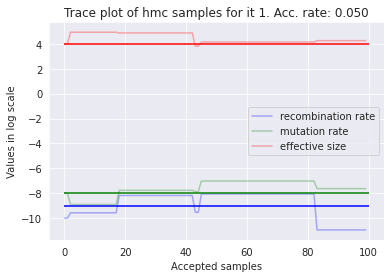

In [ ]:
mcmcgan.discriminator.run_eagerly = True
tf.config.run_functions_eagerly(True)
batch_size = 32
epochs = 10
n_reps = 2000
max_num_iters = 10
convergence = False
it = 1

# Initial guess must always be a float, otherwise with an int there are errors
initial_guesses = tf.constant([-., -8., 4.])
mcmcgan.setup_mcmc(
                  num_mcmc_results=100,
                  num_burnin_steps=30,
                  initial_guess=initial_guesses
                   )

while convergence == False and max_num_iters != it:

    start_t = time.time()

    # Uncalibrated kernels doesn't converge to the desired distribution.
    # MetropolisHastings(UncalibratedHamiltonianMonteCarlo(...)) is functionally
    # the same as HamiltonianMonteCarlo(...).
    print('Starting the MCMC sampling chain')
    sample_mean, sample_stddev, is_accepted, log_acc_rate = mcmcgan.run_chain()
    print(f'Is accepted: {is_accepted}, acc_rate: {log_acc_rate}')

    # Trace plots
    colors = ['b', 'g', 'r']
    true_vals = [-9, -8, 4]
    sns.set_style("darkgrid")
    for i in range(3):
      plt.plot(mcmcgan.samples[:, i], c=colors[i], alpha=.3)
      plt.hlines(true_vals[i], 0, len(mcmcgan.samples), zorder=4,
                 color=colors[i], label="${}$".format(i))
    plt.legend(['recombination rate', 'mutation rate', 'effective size'])
    plt.xlabel('Accepted samples')
    plt.ylabel('Values in log scale')
    plt.title(f'Trace plot of {mcmcgan.kernel_name} samples for it ' \
              f'{it}. Acc. rate: {is_accepted:.3f}')
    plt.savefig(f'./results/trace_mcmcgan_' \
                f'{mcmcgan.kernel_name}_it{it}_joint.png')
    plt.show()
    plt.clf()

    # Histogram of samples
    for i in range(3):
      sns.distplot(mcmcgan.samples[:, i], color=colors[i])
    ymax = plt.ylim()[1]
    for i in range(3):
      plt.vlines(true_vals[i], 0, ymax, color=colors[i])
    plt.ylim(0, ymax)
    plt.legend(['recombination rate', 'mutation rate', 'effective size'])
    plt.xlabel('Values in log scale')
    plt.ylabel('Density')
    plt.title(f"{mcmcgan.kernel_name} samples for iteration {it}")
    plt.savefig(f'./results/mcmcgan_{mcmcgan.kernel_name}_it{it}_joint.png')
    plt.show()
    plt.clf()

    guesses=[]

    for p in mcmcgan.genob.params.values():
      mean = np.mean(mcmcgan.samples[:, p.idx])
      std = np.std(mcmcgan.samples[:, p.idx])
      print(f'{p.name} samples with mean {mean} and std {std}')
      p.set_gauss(mean, std)
      guesses.append(mean)

    mcmcgan.initial_guess = tf.constant(guesses)

    # Prepare the training and validation datasets
    xtrain, xval, ytrain, yval = mcmcgan.genob.generate_data(n_reps, gauss=True)
    train_data = tf.data.Dataset.from_tensor_slices(
                      (xtrain.astype("float32"), ytrain))
    train_data = (
          train_data.shuffle(len(ytrain))
          .cache()
          .batch(batch_size)
          .prefetch(2)
    )

    val_data = tf.data.Dataset.from_tensor_slices((xval.astype("float32"), yval))
    val_data = (
          val_data.shuffle(len(yval))
          .cache()
          .batch(batch_size)
          .prefetch(2)
    )


    xtest, param_values = mcmcgan.genob.generate_testdata(num_reps=2000)
    test_data = tf.data.Dataset.from_tensor_slices((xtest.astype("float32")))
    test_data = (
          test_data
          .cache()
          .batch(batch_size)
          .prefetch(2)
    )


    mcmcgan.discriminator.fit(
        train_data, None, batch_size, epochs, validation_data=val_data,
        shuffle=True)

    it += 1
    if training.history['accuracy'][-1] < 0.55:
    	print('convergence')
    	convergence = True

    t = time.time() - start_t
    print(f'A single iteration of the MCMC-GAN took {t} seconds')